# Download and Install necessary files and packages

In [1]:
!rm -r Index
!rm -r abalone.data
!rm -r abalone.names

In [2]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/Index
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names

--2022-03-21 10:53:43--  http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data
Resolving archive.ics.uci.edu... 128.195.10.252
Connecting to archive.ics.uci.edu|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191873 (187K) [application/x-httpd-php]
Saving to: 'abalone.data'

abalone.data        100%[===================>] 187.38K   620KB/s    in 0.3s    

2022-03-21 10:53:43 (620 KB/s) - 'abalone.data' saved [191873/191873]

--2022-03-21 10:53:43--  http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/Index
Resolving archive.ics.uci.edu... 128.195.10.252
Connecting to archive.ics.uci.edu|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114 [application/x-httpd-php]
Saving to: 'Index'

Index               100%[===================>]     114  --.-KB/s    in 0s      

2022-03-21 10:53:44 (9.06 MB/s) - 'Index' saved [114/114]

--2022-03-21 10:53:44--  http://archive.ics.uci.edu/

In [3]:
!pip install -U libsvm-official

Requirement already up-to-date: libsvm-official in /opt/anaconda3/lib/python3.8/site-packages (3.25.0)


# Import packages

In [4]:
from libsvm.svmutil import *;
from commonutil import csr_find_scale_param, csr_scale;
from scipy import sparse;

In [5]:
import numpy as np;
#import pandas as pd;
import matplotlib.pyplot as plt;
from IPython.display import clear_output;

# Data Pre-processing: scale the data

In [6]:
# Set the one-hot encoding method
sex_encoder = {"M": ["0", "0", "1"], "F": ["1", "0", "0"], "I": ["0", "1", "0"]};
dataset, train_size, train_file, test_file =  "abalone.data", 3133, "abalone_train.txt", "abalone_test.txt";
dataset = open(dataset);
train_file = open(train_file,'w');
test_file = open(test_file,'w');

i = 0
while i < 4177:
    line = dataset.readline().split(",")
    # Convert the multi-class problem into a binary class one
    if 1 <= int(line[-1]) <=9:
        line[-1] = "1"
    else:
        line[-1] = "0"
    line = sex_encoder[line[0]] + line[1:]
    # Write the pre-processed data into new files
    if i < train_size:
        train_file.write(','.join(line)+'\n')
    else:
        test_file.write(','.join(line)+'\n')
    i += 1
train_file.close()
test_file.close()
dataset.close()

In [7]:
train_file, test_file = "abalone_train.txt", "abalone_test.txt"

x_train = sparse.csr_matrix(np.loadtxt(train_file, delimiter=","))
x_test = sparse.csr_matrix(np.loadtxt(test_file, delimiter=","))

#print(x_train.shape, x_test.shape)
for i in range(x_train.shape[1]-1):
    param = csr_find_scale_param(x_train[:, i], lower=0)
    x_train[:, i] = csr_scale(x_train[:, i], param)
    x_test[:, i] = csr_scale(x_test[:, i], param)

#print(x_train)
np.savetxt(train_file.replace('.txt', '_scaled.txt'), x_train.toarray(), delimiter=',')
np.savetxt(test_file.replace('.txt', '_scaled.txt'), x_test.toarray(), delimiter=',')

In [8]:
train_file, test_file = "abalone_train_scaled.txt", "abalone_test_scaled.txt"

train = sparse.csr_matrix(np.loadtxt(train_file, delimiter=","))
test = sparse.csr_matrix(np.loadtxt(test_file, delimiter=","))

m = train.shape[0]  #3133
x_dim = train.shape[1] - 1  #10
x_train, y_train = train[:, :x_dim].toarray(), train[:, x_dim].toarray().squeeze()
x_test, y_test = test[:, :x_dim].toarray(), test[:, x_dim].toarray().squeeze()

# Set the hyperparameter we want to tune with

In [9]:
log3c_range=10;
n_fold=5;
poly_d=5;
_t="1";

# Start training!
## Question 3

In [10]:
train_cverror_lst = np.ones((poly_d, 2 * log3c_range + 1, n_fold))
for d in range(1, poly_d+1):
    '''
    if task == "0":
        x_train_matrix = np.power(np.dot(x_train, (np.repeat(y_train.reshape(-1, 1), x_dim, axis=1) * x_train).transpose()), d)
        x_test_matrix = np.power(np.dot(x_test, (np.repeat(y_train.reshape(-1, 1), x_dim, axis=1) * x_train).transpose()), d)
        x_train_matrix, x_test_matrix = sparse.csr_matrix(x_train_matrix), sparse.csr_matrix(x_test_matrix)
    else:
        x_train_matrix, x_test_matrix = x_train, x_test
    '''
    x_train_matrix, x_test_matrix = x_train, x_test;
    for log3c in range(-log3c_range, log3c_range+1):
        print("(C,d) = (3^%s, %s)\t" % (log3c, d))
        # Shuffle the data
        indexList = np.arange(m)
        np.random.shuffle(indexList)
        x_train_shuffle, y_train_shuffle = x_train_matrix[indexList, :], y_train[indexList]
        for f in range(n_fold):
            i1, i2 = m * f // n_fold, m * (f + 1) // n_fold
            # Cross validation
            val_X, val_y = x_train_shuffle[i1:i2, :], y_train_shuffle[i1:i2]
            # train using the rest f-1 folds
            train_X = sparse.vstack([x_train_shuffle[:i1, :], x_train_shuffle[i2:, :]]).toarray()
            train_y = np.hstack([y_train_shuffle[:i1], y_train_shuffle[i2:]])
            # Train SVM
            model = svm_train(train_y, train_X, "-c %s -t %s -d %s -q" % (3**log3c, _t, d))
            eval_predy, eval_stats, eval_predval = svm_predict(val_y, val_X, model)
            # Predict using SVM and get classification error
            train_cverror_lst[d-1][log3c+log3c_range][f] = eval_stats[1]
        clear_output(wait=True);

(C,d) = (3^10, 5)	
Accuracy = 78.754% (493/626) (classification)
Accuracy = 79.5853% (499/627) (classification)
Accuracy = 80.1917% (502/626) (classification)
Accuracy = 78.4689% (492/627) (classification)
Accuracy = 79.9043% (501/627) (classification)


## Question 4

In [11]:
# find the pair (C,d) that gives smallest error
train_cverror_mean, train_cverror_std = train_cverror_lst.mean(axis=2), train_cverror_lst.std(axis=2)
argmin = train_cverror_mean.flatten().argmin()
best_log3c, best_d = int(argmin)%(2*log3c_range+1)-log3c_range, int(argmin)//(2*log3c_range+1)+1
best_C = 3 ** best_log3c
print("----------------------\n","Best (C,d) = (%s, %s)\n"%(best_C, best_d), "----------------------\n")
bestc_train_cverror = train_cverror_mean[:, best_log3c+log3c_range]

print('Now train with the best C=C* and predict with the test set\n')
bestc_test_error = np.zeros([poly_d, 1])
sv_num = np.zeros([poly_d, 1])
for d in range(1, poly_d + 1):
    '''
    if task == "0":
        x_train_matrix = np.power(np.dot(x_train, (np.repeat(y_train.reshape(-1, 1), x_dim, axis=1) * x_train).transpose()), d)
        x_test_matrix = np.power(np.dot(x_test, (np.repeat(y_train.reshape(-1, 1), x_dim, axis=1) * x_train).transpose()), d)
        x_train_matrix, x_test_matrix = sparse.csr_matrix(x_train_matrix), sparse.csr_matrix(x_test_matrix)
    else:
        x_train_matrix, x_test_matrix = x_train, x_test
    '''
    x_train_matrix, x_test_matrix = x_train, x_test
    

    # Train on the whole training data
    model = svm_train(y_train, x_train_matrix, " -c %s -t %s -d %s " % (best_C, _t, d))
    # Test on the testing data
    test_predy, test_stats, test_predval = svm_predict(y_test, x_test_matrix, model)
    # Get the metrics
    bestc_test_error[d-1] = test_stats[1]
    sv_num[d-1] = model.get_nr_sv()

----------------------
 Best (C,d) = (59049, 2)
 ----------------------

Now train with the best C=C* and predict with the test set

Accuracy = 77.9693% (814/1044) (classification)
Accuracy = 79.3103% (828/1044) (classification)
Accuracy = 78.2567% (817/1044) (classification)
Accuracy = 77.8736% (813/1044) (classification)
Accuracy = 77.4904% (809/1044) (classification)


In [12]:
print(bestc_train_cverror)
print(bestc_test_error)
print(sv_num)

[0.20267413 0.19565862 0.19949198 0.20300024 0.20619156]
[[0.22030651]
 [0.20689655]
 [0.21743295]
 [0.22126437]
 [0.22509579]]
[[1519.]
 [1453.]
 [1465.]
 [1503.]
 [1556.]]


## Question 5

In [13]:
print('Next we train with the best C=C* and d=d* but different training set size\n');
groups = 10;
bestcd_train_error = np.zeros([groups,1])
bestcd_test_error = np.zeros([groups,1])
length = len(x_train)

for g in range(groups):
    # Get a fraction of the training data
    x_train_matrix, x_test_matrix = x_train[:length*(g+1)//10], x_test
    # Train on the whole training data
    model = svm_train(y_train[:length*(g+1)//10], x_train_matrix, " -c %s -t %s -d %s " % (best_C, _t, best_d))
    # Test on the training and testing data
    train_predy, train_stats, train_predval = svm_predict(y_train[:length*(g+1)//10], x_train_matrix, model)
    test_predy, test_stats, test_predval = svm_predict(y_test, x_test_matrix, model)
    clear_output(wait=True)
    # Get the metrics
    bestcd_train_error[g] = train_stats[1]
    bestcd_test_error[g] = test_stats[1]

Accuracy = 81.0725% (2540/3133) (classification)
Accuracy = 79.3103% (828/1044) (classification)


In [14]:
print(bestcd_train_error)
print(bestcd_test_error)

[[0.12779553]
 [0.14536741]
 [0.15654952]
 [0.16839585]
 [0.17496807]
 [0.19105907]
 [0.19060648]
 [0.18076616]
 [0.18552678]
 [0.18927545]]
[[0.2816092 ]
 [0.31704981]
 [0.27203065]
 [0.20689655]
 [0.19827586]
 [0.20881226]
 [0.21264368]
 [0.20019157]
 [0.21264368]
 [0.20689655]]


# Visualization

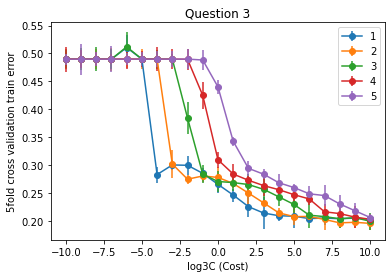

In [15]:
fig, ax = plt.subplots()
for d in range(1, poly_d+1):
    ax.errorbar(range(-log3c_range, log3c_range+1), train_cverror_mean[d-1],
            yerr=train_cverror_std[d-1],
            fmt='-o',
            label=str(d))
ax.set_xlabel('log3C (Cost)')
ax.set_ylabel('5fold cross validation train error')
ax.set_title('Question 3')
ax.legend()
plt.show();
fig.savefig('Question 3.png')

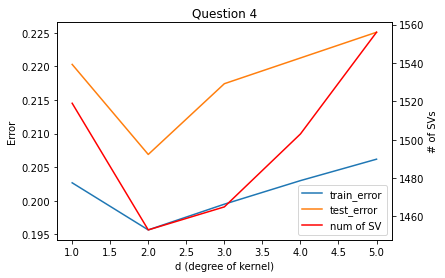

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
lns1 = ax1.plot(range(1,poly_d+1),bestc_train_cverror,label='train_error')
lns2 = ax1.plot(range(1,poly_d+1),bestc_test_error,label='test_error')
lns3 = ax2.plot(range(1, poly_d+1), sv_num,'-r',label='num of SV')
ax1.set_xlabel('d (degree of kernel)')
ax1.set_ylabel('Error')
ax2.set_ylabel('# of SVs')
ax1.set_title('Question 4')
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs,loc=0)
plt.show()
fig.savefig('Question 4.png');

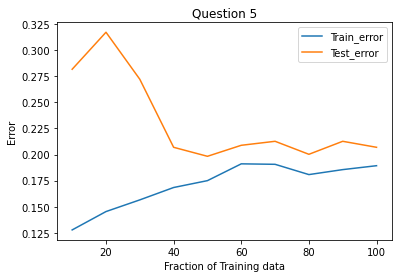

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(np.arange(10,110,10),bestcd_train_error,label='Train_error')
plt.plot(np.arange(10,110,10),bestcd_test_error,label='Test_error')
plt.xlabel('Fraction of Training data');
plt.ylabel('Error')
plt.title('Question 5')
plt.legend()
plt.show()
plt.savefig('Question 5.png')

## Question 6
To be done...

In [18]:
test_stats

(79.3103448275862, 0.20689655172413793, 0.34280314788106236)

In [21]:
model

In [22]:
model.get_nr_sv()

1453

In [23]:
model.get_SV()

[{3: 1.0,
  4: 0.5135135135135136,
  5: 0.5210084033613446,
  6: 0.084070796460177,
  7: 0.18133522224189835,
  8: 0.15030262273032954,
  9: 0.13232389730085584,
  10: 0.14798206278026907},
 {3: 1.0,
  4: 0.4932432432432433,
  5: 0.5210084033613446,
  6: 0.11061946902654868,
  7: 0.18204356295378077,
  8: 0.1442501681237391,
  9: 0.14944042132982224,
  10: 0.15296462381664178},
 {3: 1.0,
  4: 0.4797297297297297,
  5: 0.4957983193277311,
  6: 0.09734513274336283,
  7: 0.14308482380024792,
  8: 0.11197041022192335,
  9: 0.10599078341013825,
  10: 0.133034379671151},
 {3: 1.0,
  4: 0.5608108108108109,
  5: 0.546218487394958,
  6: 0.11946902654867259,
  7: 0.19107490703028154,
  8: 0.14559515803631473,
  9: 0.12442396313364054,
  10: 0.18784255107125067},
 {1: 1.0,
  4: 0.6216216216216217,
  5: 0.5882352941176471,
  6: 0.12831858407079647,
  7: 0.24172126792987425,
  8: 0.18258238063214527,
  9: 0.22448979591836735,
  10: 0.20279023418036873},
 {1: 1.0,
  4: 0.5337837837837838,
  5: 0.5042

In [24]:
model.get_sv_coef()

[(59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (15017.358691925656,),
 (12501.161063187377,),
 (50822.75471998085,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (58728.82086801933,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0,),
 (59049.0